In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm

from sklearn.manifold import TSNE

In [3]:
# Load the pretrained model
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad_(False)

In [4]:
# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# Image transforms
scaler = transforms.Scale((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

/home/cuai5th/anaconda3/envs/pytorch1.8_p38/lib/python3.8/site-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [6]:
def get_vector(image_name):
    # 1. Load the image with Pillow library
    img = Image.open(image_name)
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    t_img.shape
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data.reshape(o.data.size(1)))
#        my_embedding.copy_(o.data)
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding.numpy()

In [7]:
x_train = pd.read_csv('./SCUT-FBP5500_v2/x_train.csv')
x_train

,Rater,Filename,Rating,original Rating
0,1,AF1.jpg,2,NaN
1,1,AF10.jpg,4,NaN
2,1,AF100.jpg,3,NaN
3,1,AF1000.jpg,4,NaN
4,1,AF1001.jpg,5,NaN
...,...,...,...,...
1995,1,AF995.jpg,3,NaN
1996,1,AF996.jpg,3,NaN
1997,1,AF997.jpg,4,NaN
1998,1,AF998.jpg,3,NaN


In [8]:
img_name = x_train.iloc[:, 1]

In [9]:
img_name = list(map((lambda x:'./SCUT-FBP5500_v2/Images/'+x), img_name))

In [11]:
cnn_features = []
for i in tqdm(range(len(img_name))):
    f_v = get_vector(img_name[i])
    cnn_features.append(f_v)

100%|███████████████████████████████████████| 2000/2000 [17:54<00:00,  1.86it/s]


In [13]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.cluster import DBSCAN

In [14]:
X = np.array(cnn_features)

cluster label:  [5 1 3 ... 2 0 1]
클러스터 크기: [  0 398 383 391 369 134 325]


Text(0, 0.5, 'feature 1')

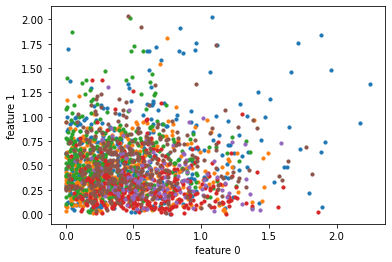

In [16]:
agg = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
assignment = agg.fit_predict(cnn_features)
print("cluster label: ", assignment)
print("클러스터 크기: {}".format(np.bincount(assignment + 1)))

plt.scatter(X[assignment == 0, 0], X[assignment == 0, 1],s=10)
plt.scatter(X[assignment == 1, 0], X[assignment == 1, 1],s=10)
plt.scatter(X[assignment == 2, 0], X[assignment == 2, 1],s=10)
plt.scatter(X[assignment == 3, 0], X[assignment == 3, 1],s=10)
plt.scatter(X[assignment == 4, 0], X[assignment == 4, 1],s=10)
plt.scatter(X[assignment == 5, 0], X[assignment == 5, 1],s=10)
plt.xlabel("feature 0")
plt.ylabel("feature 1")

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [10.0, 10.0, 30.0, 30.0],
  [45.0, 45.0, 55.0, 55.0],
  [65.0, 65.0, 75.0, 75.0],
  [50.0, 50.0, 70.0, 70.0],
  [20.0, 20.0, 60.0, 60.0],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [115.0, 115.0, 125.0, 125.0],
  [135.0, 135.0, 145.0, 145.0],
  [120.0, 120.0, 140.0, 140.0],
  [92.5, 92.5, 130.0, 130.0],
  [40.0, 40.0, 111.25, 111.25],
  [155.0, 155.0, 165.0, 165.0],
  [175.0, 175.0, 185.0, 185.0],
  [160.0, 160.0, 180.0, 180.0],
  [195.0, 195.0, 205.0, 205.0],
  [215.0, 215.0, 225.0, 225.0],
  [200.0, 200.0, 220.0, 220.0],
  [170.0, 170.0, 210.0, 210.0],
  [235.0, 235.0, 245.0, 245.0],
  [255.0, 255.0, 265.0, 265.0],
  [240.0, 240.0, 260.0, 260.0],
  [275.0, 275.0, 285.0, 285.0],
  [295.0, 295.0, 305.0, 305.0],
  [280.0, 280.0, 300.0, 300.0],
  [250.0, 250.0, 290.0, 290.0],
  [190.0, 190.0, 270.0, 270.0],
  [75.625, 75.625, 230.0, 230.0],
  [315.0, 315.0, 325.0, 325.0],
  [335.0, 335.0, 345.0, 345.0],


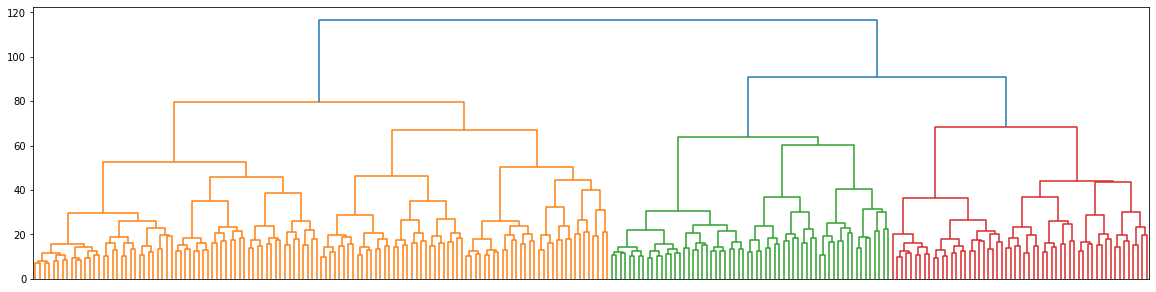

In [21]:
import scipy.cluster.hierarchy as sch

linkage_array = ward(cnn_features)
# 클러스터 사이의 거리가 담겨있는 linkage_array로 덴드로그램을 그립니다
plt.figure(figsize=(20, 5))
sch.dendrogram(linkage_array, p=7, truncate_mode='level', no_labels=True) # 7까지 깊이 제한